# Midterm-Project: Walkability Accessment of Graz, Austria

Authors: Bernadette Kakuska, Clemens Wallisch, Elias Pfleger, Paul Badin

Course: GIS analysis techniques 2 (VU, WS25)

Date: 07/12/2025

> Kevic, K., Kuveždic Divjak, A., Zrno, K., and Vilicic, M. (2024). Open Data Supporting GIS-based Walkability Assessment: Case Study for City of Zagreb, Croatia, Int. Arch. Photogramm. Remote Sens. Spatial Inf. Sci., XLVIII-5-2024, 23–29, https://doi.org/10.5194/isprs-archives-XLVIII-5-2024-23-2024.

### Data Preparation

In [1]:
# import libraries
import pandas as pd        
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx   # for computing walking distances

from keplergl import KeplerGl   # for Visualisation

import h3   # Hexagonal grid indexing for Spatial analysis


c:\Users\berna\Documents\Studium\GST_2025W\GIS_analysis_techniques2_VU\venv-gst200b-v311\Lib\site-packages\keplergl\keplergl.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


Load the districts of Graz and merge them with the pop csv  (shp data converted in QGIS from Overpass)
(source of population data: https://www.graz.at/cms/beitrag/10034466/7772565/Zahlen_Fakten_Bevoelkerung_Bezirke_Wirtschaft.html)

In [2]:
#get the districts of Graz
gdf_districts = gpd.read_file("data/districts_graz.shp")
print(gdf_districts.head(3))
print(f"\nTotal numbers of districts: {len(gdf_districts)}")

                id              @id @relations admin_leve        boundary  \
0  relation/102537  relation/102537       None          9  administrative   
1  relation/102546  relation/102546       None          9  administrative   
2  relation/102553  relation/102553       None          9  administrative   

             name    official_n postal_cod ref_at_okz      type  wikidata  \
0    Innere Stadt          None       None      17453  boundary   Q250880   
1        Liebenau          None       None       None  boundary   Q876432   
2  Sankt Leonhard  St. Leonhard       None      17454  boundary  Q1530101   

                wikipedia                                           geometry  
0  de:Innere Stadt (Graz)  POLYGON ((15.44371 47.06706, 15.44347 47.0671,...  
1      de:Liebenau (Graz)  POLYGON ((15.468 47.04249, 15.46804 47.04237, ...  
2  de:St. Leonhard (Graz)  POLYGON ((15.46177 47.06758, 15.46174 47.06756...  

Total numbers of districts: 17


             name                                           geometry
0    Innere Stadt  POLYGON ((15.44371 47.06706, 15.44347 47.0671,...
1        Liebenau  POLYGON ((15.468 47.04249, 15.46804 47.04237, ...
2  Sankt Leonhard  POLYGON ((15.46177 47.06758, 15.46174 47.06756...
3         Geidorf  POLYGON ((15.42348 47.09566, 15.42354 47.09563...


<Axes: >

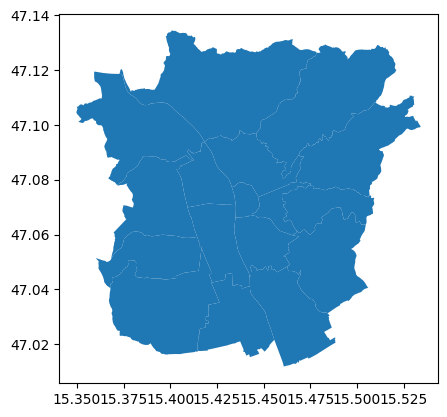

In [3]:
#extract the columns which are needed
gdf_districts = gdf_districts[["name", "geometry"]].copy()
print(gdf_districts.head(4))
gdf_districts.plot()

In [4]:
#loading csv with pop data of graz 
df_popgraz = pd.read_csv("data/Bevoelkerung Graz.csv", encoding="latin1", sep=";")
df_popgraz.head(18)

,Bezirk,Größe in km2,Einwohner,Einwohner pro km2
0,Innere Stadt,"1,16",3184,2745
1,Sankt Leonhard,"1,83",14692,8028
2,Geidorf,"5,5",23770,4322
3,Lend,"3,7",34308,9324
4,Gries,"5,05",30511,6042
5,Jakomini,"4,06",32114,7910
6,Liebenau,"7,99",16588,2076
7,Sankt Peter,"8,86",16615,1875
8,Waltendorf,"4,48",12432,2775
9,Ries,"10,16",6099,600


In [5]:
#merge the two datasets
gdf_districts_pop = gdf_districts.merge(df_popgraz, left_on="name", right_on="Bezirk")
gdf_districts_pop.head(3)

,name,geometry,Bezirk,Größe in km2,Einwohner,Einwohner pro km2
0,Innere Stadt,"POLYGON ((15.44371 47.06706, 15.44347 47.0671,...",Innere Stadt,"1,16",3184,2745
1,Liebenau,"POLYGON ((15.468 47.04249, 15.46804 47.04237, ...",Liebenau,"7,99",16588,2076
2,Sankt Leonhard,"POLYGON ((15.46177 47.06758, 15.46174 47.06756...",Sankt Leonhard,"1,83",14692,8028


Get the POIs and merge them into one GDF

In [6]:
PLACE_NAME:str = "Graz, Austria"

                                    geometry category
element id                                           
node    251710886  POINT (15.43675 47.07188)   retail
        271624001  POINT (15.47242 47.05671)   retail
        278691038   POINT (15.4427 47.06992)   retail
        288172339  POINT (15.40841 47.07185)   retail
        290422098  POINT (15.45518 47.06741)   retail


<Axes: >

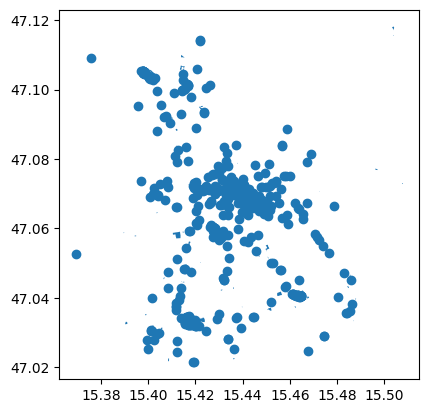

In [7]:
tags_retail = {
    "shop": [
        "clothes", "shoes", "furniture", "electronics", "computer",
        "mobile_phone", "kitchen", "houseware", "hardware", "doityourself",
        "books", "stationery", "jewelry", "boutique", "sports", "outdoor",
        "bicycle", "car", "car_repair", "motorcycle",
        "department_store", "mall", "variety_store", "general"
    ]
}

gdf_retail = ox.features_from_place(PLACE_NAME, tags_retail)
gdf_retail = gdf_retail[["geometry"]].copy()
gdf_retail["category"] = "retail"
print(gdf_retail.head(5))
gdf_retail.plot()


                                   geometry category
element id                                          
node    21015347  POINT (15.43238 47.02987)     food
        26899232  POINT (15.44826 47.07568)     food
        31611256   POINT (15.4581 47.06301)     food
        31620673   POINT (15.4342 47.02831)     food
        31620704  POINT (15.46442 47.03997)     food


<Axes: >

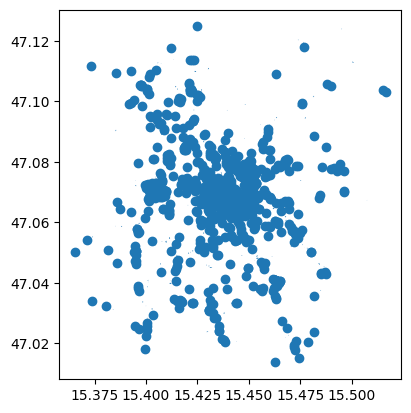

In [8]:
tags_food = {
    "amenity": [
        "supermarket", "marketplace", "greengrocer",
        "restaurant", "cafe", "fast_food", "ice_cream",
        "bar", "pub", "biergarten",
        "bakery"
    ],
    "shop": ["supermarket", "convenience", "greengrocer", "butcher", "seafood"]
}

gdf_food = ox.features_from_place(PLACE_NAME, tags_food)
gdf_food = gdf_food[["geometry"]].copy()
gdf_food["category"] = "food"
print(gdf_food.head(5))
gdf_food.plot()

                                    geometry       category
element id                                                 
node    31625435   POINT (15.43796 47.06991)  entertainment
        31625437      POINT (15.45 47.06382)  entertainment
        107935777  POINT (15.43765 47.04397)  entertainment
        251710896  POINT (15.44063 47.07142)  entertainment
        492011184  POINT (15.39263 47.07637)  entertainment


<Axes: >

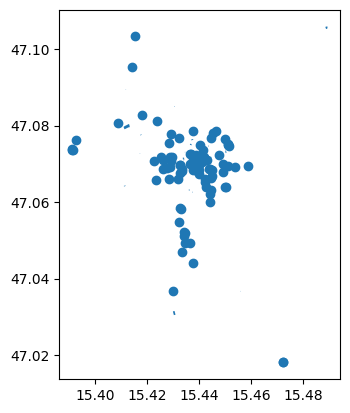

In [9]:
tags_entertainment = {
    "amenity": ["cinema", "theatre", "arts_centre", "nightclub", "casino"],
    "tourism": ["museum", "gallery"]
}

gdf_entertainment = ox.features_from_place(PLACE_NAME, tags_entertainment)
gdf_entertainment = gdf_entertainment[["geometry"]].copy()
gdf_entertainment["category"] = "entertainment"
print(gdf_entertainment.head(5))
gdf_entertainment.plot()

                                    geometry category
element id                                           
node    266657602  POINT (15.45089 47.06318)   office
        279089642  POINT (15.43966 47.07262)   office
        369490755  POINT (15.43934 47.06822)   office
        569570749  POINT (15.44646 47.07484)   office
        837234659  POINT (15.43417 47.05871)   office
<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 963 entries, ('node', np.int64(266657602)) to ('way', np.int64(1410449338))
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  963 non-null    geometry
 1   category  963 non-null    object  
dtypes: geometry(1), object(1)
memory usage: 57.9+ KB


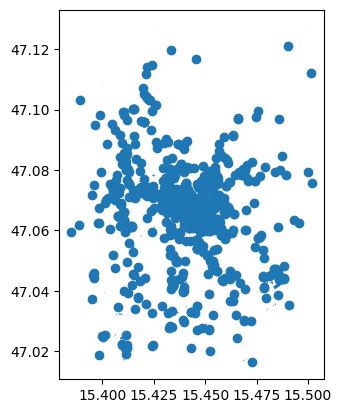

In [10]:
tags_office = {"office": True}
gdf_office = ox.features_from_place(PLACE_NAME, tags_office)
gdf_office = gdf_office[["geometry"]].copy()    
gdf_office["category"] = "office"
print(gdf_office.head(5))
gdf_office.plot()
gdf_office.info()

                                    geometry category
element id                                           
node    26899380   POINT (15.43737 47.06753)    civic
        26899638   POINT (15.46345 47.06607)    civic
        26899640   POINT (15.43932 47.06861)    civic
        117124121     POINT (15.483 47.0471)    civic
        269062537  POINT (15.41311 47.06663)    civic


<Axes: >

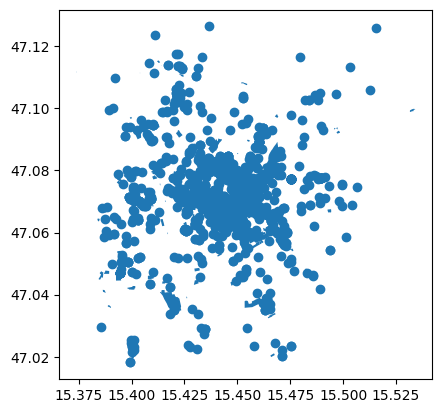

In [11]:
tags_civic = {
    "amenity": [
        "school", "university", "college",
        "hospital", "clinic", "doctors", "dentist",
        "police", "fire_station", "townhall",
        "library", "post_office", "courthouse"
    ]
}
gdf_civic = ox.features_from_place(PLACE_NAME, tags_civic)
gdf_civic = gdf_civic[["geometry"]].copy()
gdf_civic["category"] = "civic"
print(gdf_civic.head(5))
gdf_civic.plot()

                                    geometry category
element id                                           
node    197819750  POINT (15.45903 47.07323)    sport
        278113673  POINT (15.42145 47.07183)    sport
        291464359  POINT (15.45846 47.07323)    sport
        859421763  POINT (15.38524 47.09008)    sport
        940994980  POINT (15.42787 47.08845)    sport
<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 5427 entries, ('node', np.int64(197819750)) to ('way', np.int64(1452490981))
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  5427 non-null   geometry
 1   category  5427 non-null   object  
dtypes: geometry(1), object(1)
memory usage: 272.4+ KB


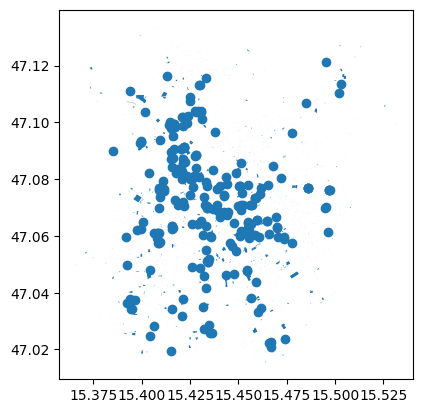

In [12]:
sport_tags = {
    "leisure": [
        "sports_centre", "pitch", "stadium", "swimming_pool", "fitness_centre",
        "playground", "miniature_golf"
    ],
}

gdf_sport = ox.features_from_place(PLACE_NAME, sport_tags)
gdf_sport = gdf_sport[["geometry"]].copy()
gdf_sport["category"] = "sport"
print(gdf_sport.head(5))
gdf_sport.plot()
gdf_sport.info()

In [13]:
#only point geometry for POIs
def only_points (gdf):
    gdf = gdf[["geometry", "category"]].copy()
    gdf = gdf.to_crs("EPSG:32633") #UTM zone 33N for Graz
    gdf['geometry'] = gdf.geometry.centroid
    gdf = gdf.to_crs("EPSG:4326") #back to WGS84
    gdf = gdf[gdf.geometry.type == "Point"].copy()
    gdf = gdf.reset_index(drop=True)
    return gdf

In [14]:
gdf_retail = only_points(gdf_retail)
gdf_food = only_points(gdf_food)
gdf_civic = only_points(gdf_civic)
gdf_sport = only_points(gdf_sport)
gdf_office = only_points(gdf_office)
gdf_entertainment = only_points(gdf_entertainment)

In [15]:
gdf_retail.head(3)

,geometry,category
0,POINT (15.43675 47.07188),retail
1,POINT (15.47242 47.05671),retail
2,POINT (15.4427 47.06992),retail


In [16]:
#final merge of all POI categories
gdf_pois = gpd.GeoDataFrame(pd.concat([gdf_retail, gdf_food, gdf_civic, gdf_sport, gdf_office, gdf_entertainment], ignore_index=True))
gdf_pois.info()
gdf_pois['category'].value_counts()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10147 entries, 0 to 10146
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  10147 non-null  geometry
 1   category  10147 non-null  object  
dtypes: geometry(1), object(1)
memory usage: 158.7+ KB


category
sport            5427
civic            1503
food             1403
office            963
retail            726
entertainment     125
Name: count, dtype: int64

Add Blues and Greens of Graz 

> Source: https://land.copernicus.eu/en/products/urban-atlas?tab=land_coverland_use

In [17]:
gdf_greenspaces = gpd.read_file("data/urban_atlas_graz.shp")
print(gdf_greenspaces.head(3))
gdf_greenspaces["class_2018"].value_counts()

       fid country fua_name fua_code code_2018  \
0  11376.0      AT     Graz  AT002L3     12220   
1  29134.0      AT     Graz  AT002L3     12230   
2  29165.0      AT     Graz  AT002L3     12230   

                        class_2018 prod_date     identifier     perimeter  \
0  Other roads and associated land   2020-08  31338-AT002L3  1.708235e+07   
1     Railways and associated land   2020-08  31641-AT002L3  4.043997e+04   
2     Railways and associated land   2020-08  31642-AT002L3  1.191133e+05   

           area comment  Pop2018  \
0  6.076743e+07    None        0   
1  3.488787e+05    None        0   
2  1.497519e+06    None        0   

                                            geometry  
0  MULTIPOLYGON (((15.43787 47.12816, 15.43792 47...  
1  POLYGON ((15.40437 47.01663, 15.40463 47.01769...  
2  POLYGON ((15.35952 47.11876, 15.35955 47.11877...  


class_2018
Discontinuous medium density urban fabric (S.L. : 30% - 50%)    905
Discontinuous dense urban fabric (S.L. : 50% -  80%)            659
Industrial, commercial, public, military and private units      614
Discontinuous low density urban fabric (S.L. : 10% - 30%)       611
Pastures                                                        339
Continuous urban fabric (S.L. : > 80%)                          274
Arable land (annual crops)                                      161
Forests                                                         155
Green urban areas                                               152
Discontinuous very low density urban fabric (S.L. : < 10%)      128
Isolated structures                                             125
Sports and leisure facilities                                    90
Land without current use                                         74
Water                                                            25
Railways and associated land         

                                            geometry         class_2018  \
0  POLYGON ((15.44205 47.03268, 15.44218 47.03274...              Water   
1  POLYGON ((15.43098 47.0345, 15.43194 47.03455,...  Green urban areas   
2  POLYGON ((15.44226 47.04103, 15.4421 47.04108,...  Green urban areas   

  code_2018  
0     50000  
1     14100  
2     14100  


<Axes: >

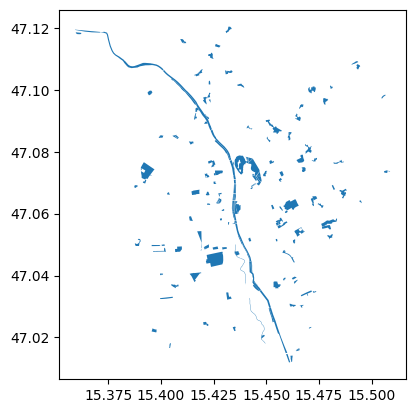

In [18]:
gdf_greens_blue = gdf_greenspaces[gdf_greenspaces["class_2018"].isin(["Green urban areas", "Water"])].copy()
gdf_greens_blue = gdf_greens_blue[["geometry", "class_2018", "code_2018"]].copy()
gdf_greens_blue = gdf_greens_blue.reset_index(drop=True)
print(gdf_greens_blue.head(3))
gdf_greens_blue.plot()

Get the walking network of Graz for routing


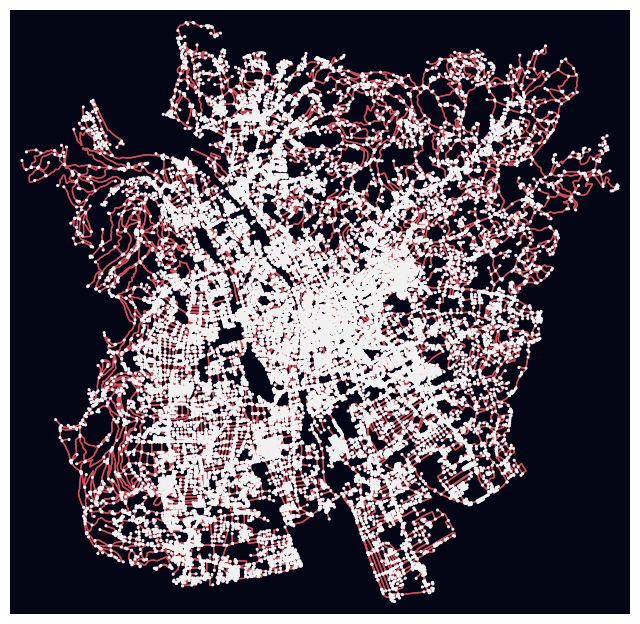

In [19]:
G = ox.graph_from_place(PLACE_NAME, network_type="walk")
G = ox.project_graph(G, to_crs = "EPSG:32633")
fig, ax = ox.plot_graph(G, node_size=5, bgcolor= "#040615", node_color='#f1f1f1', edge_color='#d44e5c')

### Analysis

Create H3-Grid

           name                                           geometry  \
0  Innere Stadt  POLYGON ((15.43705 47.07588, 15.43486 47.07135...   
1      Liebenau  POLYGON ((15.45699 47.05012, 15.4548 47.04559,...   
2      Liebenau  POLYGON ((15.45043 47.03654, 15.44824 47.03201...   
3      Liebenau  POLYGON ((15.45578 47.02079, 15.45359 47.01626...   
4      Liebenau  POLYGON ((15.44775 47.04441, 15.44557 47.03988...   

         Bezirk Größe in km2  Einwohner  Einwohner pro km2         h3_cells  
0  Innere Stadt         1,16       3184               2745  881e10a12bfffff  
1      Liebenau         7,99      16588               2076  881e10aac3fffff  
2      Liebenau         7,99      16588               2076  881e10aa8dfffff  
3      Liebenau         7,99      16588               2076  881e10aaabfffff  
4      Liebenau         7,99      16588               2076  881e10aac7fffff  


<Axes: >

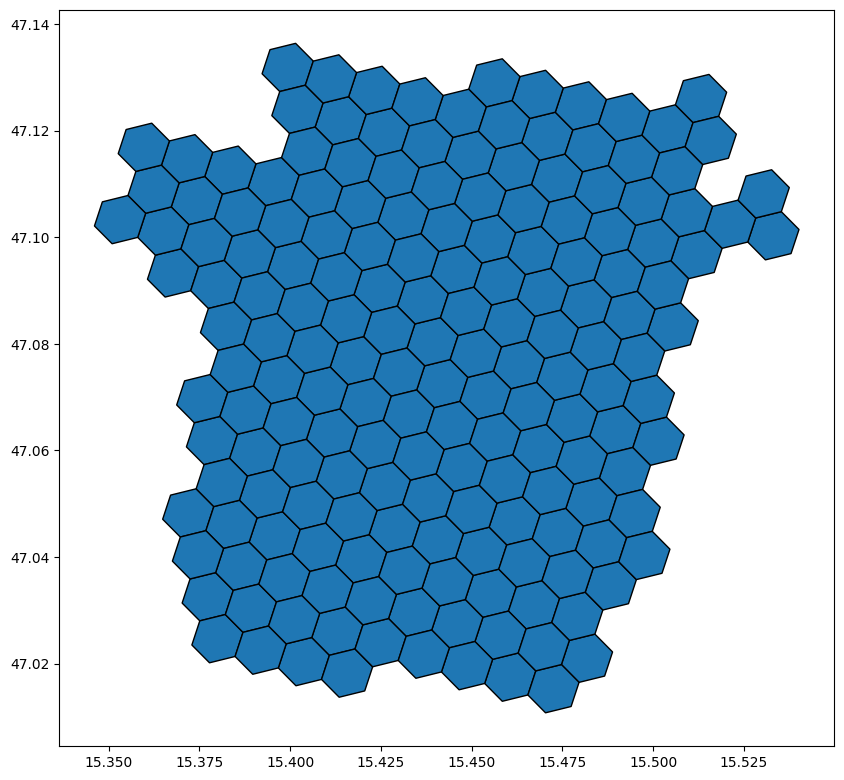

In [20]:
H3_RESOLUTION = 8  # Kevic et al. (2024) uses 500 m × 500 m square grid -> h3res=8 for Graz ~500m hexagons 

# function to convert a shapely polygon to H3 cells (v4 API)
def polygon_to_h3(polygon: Polygon, resolution=H3_RESOLUTION):
    """
    Converts a shapely Polygon to a list of H3 hex IDs.
    Works with H3 v4.x API.
    """
    # shapely uses (x=lon, y=lat), H3 expects (lat, lon)
    exterior = [(lat, lon) for lon, lat in polygon.exterior.coords]
    
    # handle interiors (holes)
    interiors = [[(lat, lon) for lon, lat in interior.coords] for interior in polygon.interiors]

    # create H3 LatLng polygon
    shape = h3.LatLngPoly(exterior, interiors)
    
    # get all H3 hexagons covering the polygon
    return list(h3.polygon_to_cells(shape, resolution))


# apply to all districts (use combined dataset)
gdf_districts_pop["h3_cells"] = gdf_districts_pop["geometry"].apply(polygon_to_h3)

# explode into one row per H3 cell for easier analysis
gdf_hex = gdf_districts_pop.explode("h3_cells").reset_index(drop=True)

# convert H3 cells to shapely polygons (v4.x API)
gdf_hex["geometry"] = gdf_hex["h3_cells"].apply(
    lambda cell: Polygon([
        (lon, lat) for lat, lon in h3.cell_to_boundary(cell)
    ])
)

# create geodataframe
gdf_hex = gpd.GeoDataFrame(gdf_hex, geometry="geometry", crs="EPSG:4326")

# check result
print(gdf_hex.head())
gdf_hex.plot(edgecolor="k", figsize=(10,10))

Connect POIs + H3

In [21]:
# Assign each POI to an H3 cel
def point_to_h3(point, res=H3_RESOLUTION):
    lat, lon = point.y, point.x
    return h3.latlng_to_cell(lat, lon, res)

gdf_pois["h3_cell"] = gdf_pois["geometry"].apply(point_to_h3)
# Now every POI has the H3 cell in which it lies.

In [22]:
# Prepare hex centroids (for distances)
gdf_hex["centroid"] = gdf_hex.geometry.centroid
gdf_hex["lat"] = gdf_hex.centroid.y
gdf_hex["lon"] = gdf_hex.centroid.x

C:\Users\berna\AppData\Local\Temp\ipykernel_43956\212735153.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_hex["centroid"] = gdf_hex.geometry.centroid
C:\Users\berna\AppData\Local\Temp\ipykernel_43956\212735153.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_hex["lat"] = gdf_hex.centroid.y
C:\Users\berna\AppData\Local\Temp\ipykernel_43956\212735153.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_hex["lon"] = gdf_hex.centroid.x


In [23]:
# Build a nearest-POI lookup using pandas merge + groupby
pois_df = pd.DataFrame({
    "h3_cell": gdf_pois["h3_cell"],
    "poi_lat": gdf_pois.geometry.y,
    "poi_lon": gdf_pois.geometry.x,
    "category": gdf_pois["category"]
})

Compute distance to nearest POI per hex

In [24]:
# using haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # meters
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))


# using the haversine, not reprojecting to UTM because haversine expects lat/lon

In [26]:
# compute minimum distance per hex × category
result = []

for cat in pois_df["category"].unique():
    subset = pois_df[pois_df["category"] == cat]

    # merge hex grid with POIs of this category
    merged = gdf_hex.merge(subset, how="cross")

    merged["distance_m"] = haversine(
        merged["lat"], merged["lon"],
        merged["poi_lat"], merged["poi_lon"],
    )

    # keep nearest POI
    nearest = merged.loc[
        merged.groupby("h3_cells")["distance_m"].idxmin(),
        ["h3_cells", "category", "distance_m"]
    ]

    result.append(nearest)

gdf_distances = pd.concat(result)
gdf_distances = gdf_distances.reset_index(drop=True)

print(gdf_distances.head())
print(gdf_distances.tail())
print(f"\nAmount: {len(gdf_distances)}")



          h3_cells category   distance_m
0  881e10a001fffff   retail  1165.183051
1  881e10a005fffff   retail   284.720878
2  881e10a007fffff   retail   920.492560
3  881e10a021fffff   retail  1100.783563
4  881e10a023fffff   retail  1288.845060
             h3_cells       category   distance_m
1057  881e10b8b9fffff  entertainment  1916.775165
1058  881e10b8bbfffff  entertainment  1408.312021
1059  881e10b8c3fffff  entertainment  4486.872705
1060  881e10b8d5fffff  entertainment  3557.591741
1061  881e10b8d7fffff  entertainment  2631.113038

Amount: 1062


In [27]:
# Attach geodataframe with distances to hex grid
gdf_hex = gdf_hex.merge(gdf_distances, on="h3_cells", how="left")
print(gdf_hex.head())

           name                                           geometry  \
0  Innere Stadt  POLYGON ((15.43705 47.07588, 15.43486 47.07135...   
1  Innere Stadt  POLYGON ((15.43705 47.07588, 15.43486 47.07135...   
2  Innere Stadt  POLYGON ((15.43705 47.07588, 15.43486 47.07135...   
3  Innere Stadt  POLYGON ((15.43705 47.07588, 15.43486 47.07135...   
4  Innere Stadt  POLYGON ((15.43705 47.07588, 15.43486 47.07135...   

         Bezirk Größe in km2  Einwohner  Einwohner pro km2         h3_cells  \
0  Innere Stadt         1,16       3184               2745  881e10a12bfffff   
1  Innere Stadt         1,16       3184               2745  881e10a12bfffff   
2  Innere Stadt         1,16       3184               2745  881e10a12bfffff   
3  Innere Stadt         1,16       3184               2745  881e10a12bfffff   
4  Innere Stadt         1,16       3184               2745  881e10a12bfffff   

                    centroid        lat        lon category  distance_m  
0  POINT (15.44191 47.07254)  

Walking distances to the POIs

In [28]:
# Reproject hex centroids and POIs into EPSG:32633 to match CRS of street network
gdf_hex_utm = gdf_hex.to_crs("EPSG:32633")
gdf_hex_utm["centroid"] = gdf_hex_utm.geometry.centroid
gdf_hex_utm["x"] = gdf_hex_utm.centroid.x
gdf_hex_utm["y"] = gdf_hex_utm.centroid.y

gdf_pois_utm = gdf_pois.to_crs("EPSG:32633")
gdf_pois_utm["x"] = gdf_pois_utm.geometry.x
gdf_pois_utm["y"] = gdf_pois_utm.geometry.y

In [45]:
# Make sure gdf_hex_utm has "x" and "y" (centroids in UTM)
gdf_hex_utm["centroid"] = gdf_hex_utm.geometry.centroid
gdf_hex_utm["x"] = gdf_hex_utm.centroid.x
gdf_hex_utm["y"] = gdf_hex_utm.centroid.y

# Snap H3 centroids to nearest OSM nodes
gdf_hex_utm["osmid"] = ox.nearest_nodes(G, gdf_hex_utm["x"], gdf_hex_utm["y"])
print(gdf_hex_utm.head())

# Snap POIs to network
gdf_pois_utm["osmid"] = ox.nearest_nodes(G, gdf_pois_utm["x"], gdf_pois_utm["y"])
print("\n", gdf_pois_utm.head())



           name                                           geometry  \
0  Innere Stadt  POLYGON ((533179.629 5213688.708, 533016.36 52...   
1  Innere Stadt  POLYGON ((533179.629 5213688.708, 533016.36 52...   
2  Innere Stadt  POLYGON ((533179.629 5213688.708, 533016.36 52...   
3  Innere Stadt  POLYGON ((533179.629 5213688.708, 533016.36 52...   
4  Innere Stadt  POLYGON ((533179.629 5213688.708, 533016.36 52...   

         Bezirk Größe in km2  Einwohner  Einwohner pro km2         h3_cells  \
0  Innere Stadt         1,16       3184               2745  881e10a12bfffff   
1  Innere Stadt         1,16       3184               2745  881e10a12bfffff   
2  Innere Stadt         1,16       3184               2745  881e10a12bfffff   
3  Innere Stadt         1,16       3184               2745  881e10a12bfffff   
4  Innere Stadt         1,16       3184               2745  881e10a12bfffff   

                         centroid        lat        lon category  distance_m  \
0  POINT (533551.084 521

In [49]:
# Compute walking distance for each category
walk_dist_list = []

# Loop over categories
for cat_name  in gdf_pois_utm["category"].unique():

    # OSM node IDs for all POIs of this type
    sources = list(gdf_pois_utm.loc[gdf_pois_utm["category"] == cat_name, "osmid"].unique())

    # Multi-source Dijkstra -> calculates the shortest walking distance along the network from every node in G to the nearest POI of the current category
    dist_dict = nx.multi_source_dijkstra_path_length(G, sources=sources, weight="length")

    # attach results to H3 grid (in UTM)
    temp = gdf_hex_utm[["h3_cells", "osmid"]].copy()
    temp["category"] = cat_name
    temp["distance_m_walk"] = temp["osmid"].map(dist_dict)

    # Store temporary results
    walk_dist_list.append(temp)

# Combine all categories
gdf_walk_distances = pd.concat(walk_dist_list).reset_index(drop=True)
gdf_walk_distances.head()



,h3_cells,osmid,category,distance_m_walk
0,881e10a12bfffff,2400327974,retail,107.712978
1,881e10a12bfffff,2400327974,retail,107.712978
2,881e10a12bfffff,2400327974,retail,107.712978
3,881e10a12bfffff,2400327974,retail,107.712978
4,881e10a12bfffff,2400327974,retail,107.712978


Define weighting for POIs (based on Kevic et al. 2024)

In [50]:
# create dicts for POIs categories
# Leisure perspective
weights_leisure = {
    "retail": [3, 1, 1],
    "food": [3, 1, 1],
    "entertainment": [3, 1],
    "office": [3],
    "civic": [3],
    "sport": [3]
}

# Daily obligations perspective
weights_daily = {
    "retail": [3, 1],
    "food": [3, 1],
    "entertainment": [3, 1],
    "office": [3, 1],
    "civic": [3, 1, 1],
    "sport": [3]
}


In [51]:
# Assign weights based on distance ranking
def poi_weights(df, weight_dict):
    """
    df: gdf_walk_distances (with columns h3_cells, category, distance_m_walk)
    weight_dict: dictionary of weights per category
    """
    df_weighted = df.copy()
    df_weighted["weight"] = 0  # initialize weight column

    for cat_name in df_weighted["category"].unique():
        cat_df = df_weighted[df_weighted["category"] == cat_name]
        weights = weight_dict.get(cat_name, [1])  # default to 1 if category missing

        # Rank POIs by distance per H3 cell
        cat_df = cat_df.sort_values(["h3_cells", "distance_m_walk"])
        df_weighted.loc[cat_df.index, "weight"] = cat_df.groupby("h3_cells")["distance_m_walk"].rank(
            method="first", ascending=True
        ).apply(lambda x: weights[int(x)-1] if int(x)-1 < len(weights) else weights[-1])

    return df_weighted


Applying the POI weights function

In [57]:
# leisure perspective
gdf_walk_leisure = poi_weights(gdf_walk_distances, weights_leisure)
gdf_walk_leisure.head()

,h3_cells,osmid,category,distance_m_walk,weight
0,881e10a12bfffff,2400327974,retail,107.712978,3
1,881e10a12bfffff,2400327974,retail,107.712978,1
2,881e10a12bfffff,2400327974,retail,107.712978,1
3,881e10a12bfffff,2400327974,retail,107.712978,1
4,881e10a12bfffff,2400327974,retail,107.712978,1


In [59]:
# daily obligations perspective
gdf_walk_daily = poi_weights(gdf_walk_distances, weights_daily)
gdf_walk_daily.head()

,h3_cells,osmid,category,distance_m_walk,weight
0,881e10a12bfffff,2400327974,retail,107.712978,3
1,881e10a12bfffff,2400327974,retail,107.712978,1
2,881e10a12bfffff,2400327974,retail,107.712978,1
3,881e10a12bfffff,2400327974,retail,107.712978,1
4,881e10a12bfffff,2400327974,retail,107.712978,1


In [62]:
# checking results e.g. for distance ranking (single h3 cell and a category)
cell = "881e10a12bfffff"
category = "retail"

subset = gdf_walk_leisure[(gdf_walk_leisure["h3_cells"] == cell) & 
                           (gdf_walk_leisure["category"] == category)]
print(subset.sort_values("distance_m_walk"))


          h3_cells       osmid category  distance_m_walk  weight
0  881e10a12bfffff  2400327974   retail       107.712978       3
1  881e10a12bfffff  2400327974   retail       107.712978       1
2  881e10a12bfffff  2400327974   retail       107.712978       1
3  881e10a12bfffff  2400327974   retail       107.712978       1
4  881e10a12bfffff  2400327974   retail       107.712978       1
5  881e10a12bfffff  2400327974   retail       107.712978       1


In [64]:
# checking results e.g. Compare leisure vs daily weights (same h3 cell and category in leisure and daily obligations)
subset_leisure = gdf_walk_leisure[gdf_walk_leisure["h3_cells"] == cell]
subset_daily = gdf_walk_daily[gdf_walk_daily["h3_cells"] == cell]

print(subset_leisure)
print(subset_daily)

             h3_cells       osmid       category  distance_m_walk  weight
0     881e10a12bfffff  2400327974         retail       107.712978       3
1     881e10a12bfffff  2400327974         retail       107.712978       1
2     881e10a12bfffff  2400327974         retail       107.712978       1
3     881e10a12bfffff  2400327974         retail       107.712978       1
4     881e10a12bfffff  2400327974         retail       107.712978       1
5     881e10a12bfffff  2400327974         retail       107.712978       1
1062  881e10a12bfffff  2400327974           food        65.139617       3
1063  881e10a12bfffff  2400327974           food        65.139617       1
1064  881e10a12bfffff  2400327974           food        65.139617       1
1065  881e10a12bfffff  2400327974           food        65.139617       1
1066  881e10a12bfffff  2400327974           food        65.139617       1
1067  881e10a12bfffff  2400327974           food        65.139617       1
2124  881e10a12bfffff  2400327974     

In [65]:
# checking number of weights per category
gdf_walk_leisure.groupby("category")["weight"].value_counts()


category       weight
civic          3         1062
entertainment  1          885
               3          177
food           1          885
               3          177
office         3         1062
retail         1          885
               3          177
sport          3         1062
Name: count, dtype: int64